# **Image Classification Using SVM with Various Feature Extraction**

This project classifies images as "*Glazed*" or "*Unglazed*" using SVM models trained on three different feature extraction methods:

1. **Color Histogram**
2. **HOG (Histogram of Oriented Gradients)**
3. **SIFT + ORB Combined Descriptors**

## **Dataset Summary**
- **Train Set (75%)**: 18 images (9 for each class)
- **Test Set (25%)**: 6 images (3 for each class)

## **Key Results**
The models were evaluated based on precision, recall, F1-score, and accuracy to identify the most effective feature extraction methods for distinguishing images between the classes.

This evaluation focuses on determining which feature extraction technique provides the most consistent and reliable performance for the classification task.

In [ ]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from skimage.feature import hog
from PIL import Image

# Load and Preprocess Images
def load_images(dataset_path, image_size=(256, 256)):
    images = []
    labels = []
    class_names = os.listdir(dataset_path)

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path).convert('RGB')
            img = img.resize(image_size)
            images.append(np.array(img))
            labels.append(class_index)

    return np.array(images), np.array(labels), class_names

# Feature Extraction Functions
def extract_color_histogram(image):
    chans = cv2.split(image)
    hist = [cv2.calcHist([chan], [0], None, [256], [0, 256]).flatten() for chan in chans]
    return np.concatenate(hist)

def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features, _ = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

def extract_sift_orb_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # SIFT
    sift = cv2.SIFT_create()
    keypoints_sift, descriptors_sift = sift.detectAndCompute(gray, None)

    # ORB
    orb = cv2.ORB_create()
    keypoints_orb, descriptors_orb = orb.detectAndCompute(gray, None)

    max_descriptors = 512

    if descriptors_sift is not None:
        descriptors_sift = descriptors_sift[:max_descriptors]  # Limit to max descriptors
    else:
        descriptors_sift = np.zeros((max_descriptors, 128))  # Padding if no descriptors

    if descriptors_orb is not None:
        descriptors_orb = descriptors_orb[:max_descriptors]  # Limit to max descriptors
    else:
        descriptors_orb = np.zeros((max_descriptors, 32))  # Padding if no descriptors

    # Ensure fixed-length descriptors (padding to max descriptors)
    descriptors_sift = np.pad(descriptors_sift, ((0, max_descriptors - descriptors_sift.shape[0]), (0, 0)), mode='constant')
    descriptors_orb = np.pad(descriptors_orb, ((0, max_descriptors - descriptors_orb.shape[0]), (0, 0)), mode='constant')

    # Flatten descriptors to create a fixed-size feature vector
    combined_descriptors = np.hstack((descriptors_sift.flatten(), descriptors_orb.flatten()))

    return combined_descriptors

# Helper to extract features
def extract_features(images, feature_extractor):
    features = []
    for image in images:
        feature = feature_extractor(image)
        features.append(feature)
    return np.array(features)

# Load train and test images
train_path = "/content/drive/MyDrive/Coding/CV GLAZE/Dataset New/Train"
test_path = "/content/drive/MyDrive/Coding/CV GLAZE/Dataset New/Test"
image_size = (256, 256)

# Load train and test images
train_images, train_labels, class_names_train = load_images(train_path, image_size)
test_images, test_labels, class_names_test = load_images(test_path, image_size)

# Extract features for each method (train set)
X_train_color = extract_features(train_images, extract_color_histogram)
X_train_hog = extract_features(train_images, extract_hog_features)
X_train_sift_orb = extract_features(train_images, extract_sift_orb_features)

# Standardize Features (train set)
scaler_color = StandardScaler()
X_train_color = scaler_color.fit_transform(X_train_color)

scaler_hog = StandardScaler()
X_train_hog = scaler_hog.fit_transform(X_train_hog)

scaler_sift_orb = StandardScaler()
X_train_sift_orb = scaler_sift_orb.fit_transform(X_train_sift_orb)

# Train SVM Models function
def train_svm(X_train, y_train, kernel='linear'):
    svm_model = SVC(kernel=kernel, random_state=42)
    svm_model.fit(X_train, y_train)
    return svm_model

# Train models with different feature sets
svm_model_color = train_svm(X_train_color, train_labels)
svm_model_hog = train_svm(X_train_hog, train_labels)
svm_model_sift_orb = train_svm(X_train_sift_orb, train_labels)

# Function to preprocess the image and extract features (test images)
def preprocess_image(img, image_size=(256, 256)):
    # Resize and convert the image to RGB
    img = Image.fromarray(img).convert('RGB')
    img = img.resize(image_size)
    img = np.array(img)

    # Extract features for each method
    color_features = extract_color_histogram(img)
    hog_features = extract_hog_features(img)
    sift_orb_features = extract_sift_orb_features(img)

    # Standardize the features using the trained scalers
    color_features = scaler_color.transform([color_features])
    hog_features = scaler_hog.transform([hog_features])
    sift_orb_features = scaler_sift_orb.transform([sift_orb_features])

    return color_features, hog_features, sift_orb_features

# Predict using all three models (test images)
def predict_image_class(img):
    # Preprocess the input image
    color_features, hog_features, sift_orb_features = preprocess_image(img)

    # Make predictions using the three models
    prediction_color = svm_model_color.predict(color_features)
    prediction_hog = svm_model_hog.predict(hog_features)
    prediction_sift_orb = svm_model_sift_orb.predict(sift_orb_features)

    # Return the predictions from all three models
    return prediction_color[0], prediction_hog[0], prediction_sift_orb[0]

# Make predictions on the test set
y_pred_color = []
y_pred_hog = []
y_pred_sift_orb = []

for img in test_images:
    prediction_color, prediction_hog, prediction_sift_orb = predict_image_class(img)
    y_pred_color.append(prediction_color)
    y_pred_hog.append(prediction_hog)
    y_pred_sift_orb.append(prediction_sift_orb)

# Convert predictions to numpy arrays
y_pred_color = np.array(y_pred_color)
y_pred_hog = np.array(y_pred_hog)
y_pred_sift_orb = np.array(y_pred_sift_orb)

# Classification report
print("Classification Report for Color Histogram Model:")
print(classification_report(test_labels, y_pred_color, target_names=class_names_test))

print("Classification Report for HOG Features Model:")
print(classification_report(test_labels, y_pred_hog, target_names=class_names_test))

print("Classification Report for SIFT+ORB Features Model:")
print(classification_report(test_labels, y_pred_sift_orb, target_names=class_names_test))

Classification Report for Color Histogram Model:
              precision    recall  f1-score   support

    Unglazed       0.50      0.33      0.40         3
      Glazed       0.50      0.67      0.57         3

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.50      0.50      0.49         6

Classification Report for HOG Features Model:
              precision    recall  f1-score   support

    Unglazed       0.00      0.00      0.00         3
      Glazed       0.50      1.00      0.67         3

    accuracy                           0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6

Classification Report for SIFT+ORB Features Model:
              precision    recall  f1-score   support

    Unglazed       0.50      0.33      0.40         3
      Glazed       0.50      0.67      0.57         3

    accuracy                        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Save Model**

In [ ]:
import pickle

# Save the SVM models
with open('svm_model_color.pkl', 'wb') as file:
    pickle.dump(svm_model_color, file)

with open('svm_model_hog.pkl', 'wb') as file:
    pickle.dump(svm_model_hog, file)

with open('svm_model_sift_orb.pkl', 'wb') as file:
    pickle.dump(svm_model_sift_orb, file)

# Save the scalers
with open('scaler_color.pkl', 'wb') as file:
    pickle.dump(scaler_color, file)

with open('scaler_hog.pkl', 'wb') as file:
    pickle.dump(scaler_hog, file)

with open('scaler_sift_orb.pkl', 'wb') as file:
    pickle.dump(scaler_sift_orb, file)

print("Models and scalers have been saved successfully.")

Models and scalers have been saved successfully.


## **Evaluation and Conclusion for the Classification**

The three models show distinct performances based on their evaluation metrics:

- **Color Histogram Model**:  
  Achieved an accuracy of **50%**, with a balanced precision of **0.5** for both classes. The recall for the *glazed* class is higher (**0.67**), leading to a slightly better F1-score of **0.57** for this class.

- **HOG Features Model**:  
  Also reached **50%** accuracy but struggled with the *unglazed* class, having a precision, recall, and F1-score of **0.0**. Its performance relies entirely on correctly identifying the *glazed* class (F1-score: **0.67**).

- **SIFT + ORB Features Model**:  
  Performed identically to the Color Histogram Model with an accuracy of **50%** and similar class-wise F1-scores, indicating balanced predictions.

### Conclusion:  
The **Color Histogram** and **SIFT + ORB Features** models demonstrate more balanced predictions across classes compared to the **HOG Features Model**, which is highly biased. Future improvements should focus on increasing dataset size and refining feature extraction methods.

# **Keypoint Matching Evaluation**

To measure the effectiveness of the glazing technique, we used **SIFT and ORB feature extraction methods alongside the BFMatcher algorithm**. The goal is to identify how well the glazing disrupts local feature matching between glazed and unglazed images. A **lower match percentage indicates higher disruption, demonstrating the effectiveness** of the glazing technique.

Below is the code used for keypoint matching:

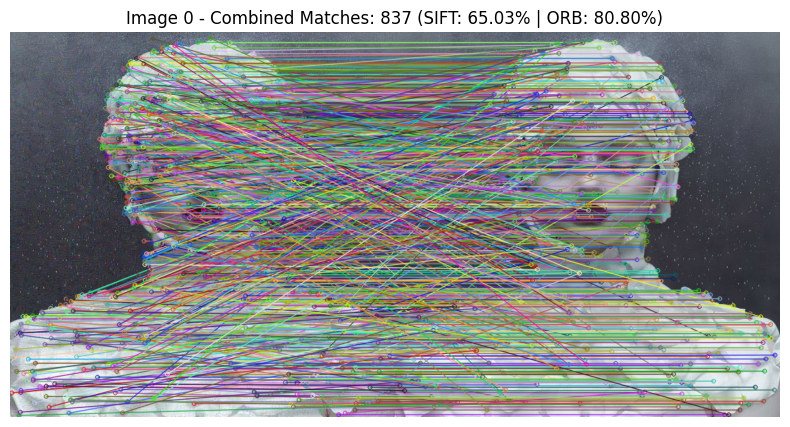

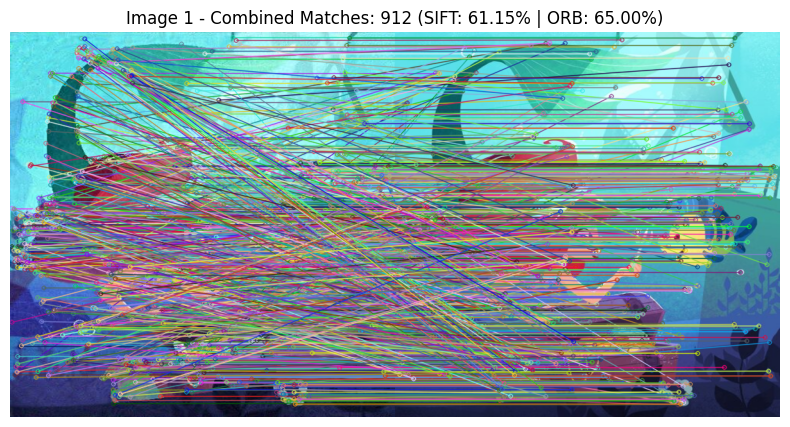

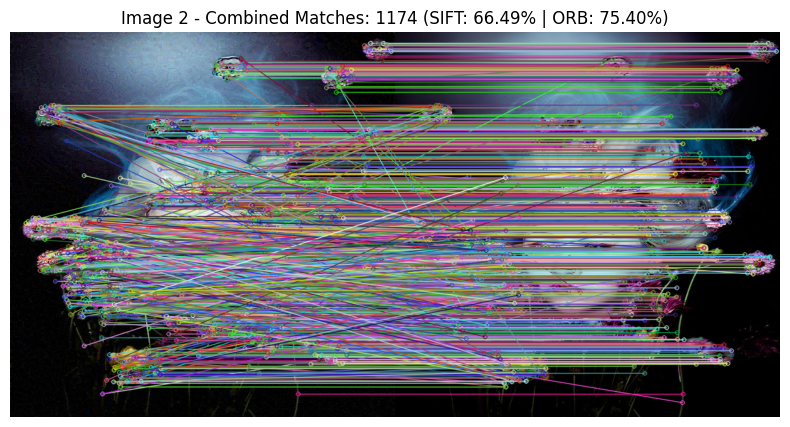

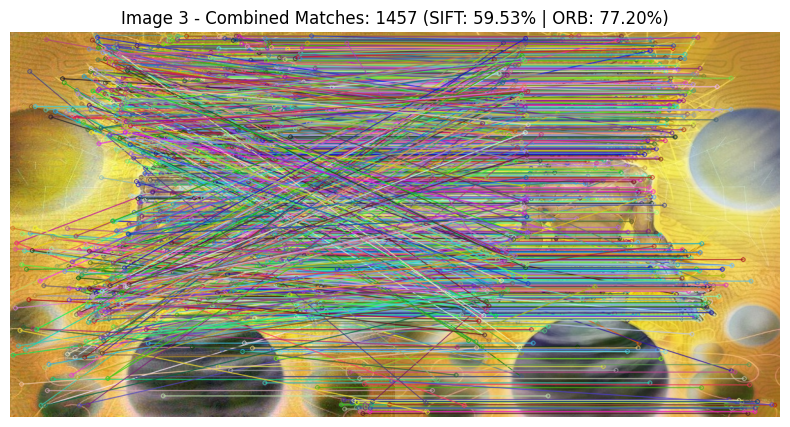

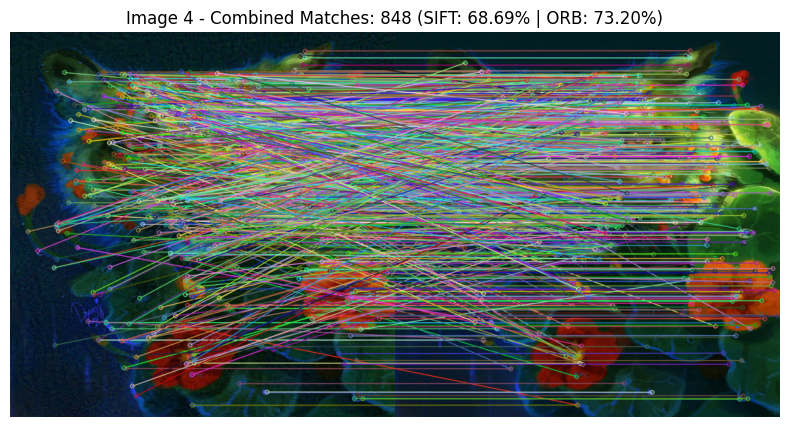

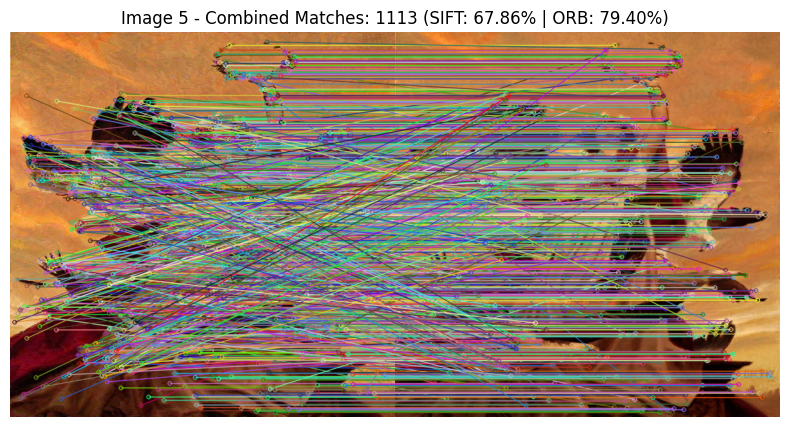

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

# Set directories
glazed_dir = '/content/drive/MyDrive/Coding/CV GLAZE/Keypoint Matching/Glazed'
unglazed_dir = '/content/drive/MyDrive/Coding/CV GLAZE/Keypoint Matching/Unglazed'

# Initialize SIFT and ORB
sift = cv2.SIFT_create()
orb = cv2.ORB_create()

# Function for keypoint matching using BFMatcher
def keypoint_matching(img1, img2, feature_extractor):
    kp1, des1 = feature_extractor.detectAndCompute(img1, None)
    kp2, des2 = feature_extractor.detectAndCompute(img2, None)
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    return kp1, kp2, matches

# Get the number of images in the directories
glazed_files = [f for f in os.listdir(glazed_dir) if f.endswith('.jpg')]
unglazed_files = [f for f in os.listdir(unglazed_dir) if f.endswith('.jpg')]

# Ensure both directories have the same number of images
num_images = min(len(glazed_files), len(unglazed_files))

# Loop through the available image files
for i in range(num_images):
    # Read images
    img_glazed = cv2.imread(os.path.join(glazed_dir, glazed_files[i]))
    img_unglazed = cv2.imread(os.path.join(unglazed_dir, unglazed_files[i]))

    # Resize images for visualization
    img_glazed, img_unglazed = cv2.resize(img_glazed, (600, 600)), cv2.resize(img_unglazed, (600, 600))

    # Perform keypoint matching with SIFT and ORB
    kp_glazed_sift, kp_unglazed_sift, matches_sift = keypoint_matching(img_glazed, img_unglazed, sift)
    kp_glazed_orb, kp_unglazed_orb, matches_orb = keypoint_matching(img_glazed, img_unglazed, orb)

    # Calculate match percentages for SIFT and ORB
    match_percentage_sift = (len(matches_sift) / min(len(kp_glazed_sift), len(kp_unglazed_sift))) * 100 if len(kp_glazed_sift) > 0 and len(kp_unglazed_sift) > 0 else 0
    match_percentage_orb = (len(matches_orb) / min(len(kp_glazed_orb), len(kp_unglazed_orb))) * 100 if len(kp_glazed_orb) > 0 and len(kp_unglazed_orb) > 0 else 0

    # Combine SIFT and ORB matches, remove duplicates
    combined_matches = list({match.queryIdx: match for match in matches_sift + matches_orb}.values())

    # Draw matches
    img_matches_combined = cv2.drawMatches(img_glazed, kp_glazed_sift, img_unglazed, kp_unglazed_sift, combined_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(img_matches_combined, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {i} - Combined Matches: {len(combined_matches)} (SIFT: {match_percentage_sift:.2f}% | ORB: {match_percentage_orb:.2f}%)')
    plt.axis('off')
    plt.show()

## **Conclusion from BF Matcher Results**

The evaluation was conducted on sample images, where the average match percentage for both SIFT and ORB ranged between **60% and 70%**. These results indicate that the glazing technique **successfully modifies** the visual style of the glazed images. While some matches remain, the **60-70% range** demonstrates that the technique effectively reduces local feature matching, making it harder for AI models to replicate the original style.